# TTA-45046 Financial Engineering, Project Work
Arttu Saarinen, arttu.saarinen@tuni.fi, 246061

### Code contents
 1. Imports
 2. Functions
 3. File reading and preparing data
 4. 1 Expected payoff at t_20 and fair value of the contract
 5. 2 Quantiles of the payoff 
 6. 3 How different weights affect the payoff
 7. 4 Make a plot of the expected payoff against different risk free rates and different volatility values
 8. 5 Set a cap to payoff 
 9. 6 Find the value of the contract on 25 March 2019
 10. 7 Inverse reasoning
 11. 8 Overall comment on the contract
 

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import timeit

start_time = timeit.default_timer()

# Main settings:
m = 10**3 # Number of paths

## Functions


In [2]:
# Returns payoff of the basket according to the basket values and minimum supplemental amount 
def basketPayoff(B, S_m, cap=None):
    C = np.mean(B) #basket closing value
    B_r = (C - B[0]) / B[0] #basket percent change
    SupplAmt = np.max([1000 * B_r, S_m]) #supplemental amount
    P = 1000 + SupplAmt #payoff
    if cap != None:
        P = np.min([P, cap])
    return P

# Returns the multiplication vector M defined with 
# certain date's prices
def M_(data, date, W):
    M = np.array([W[0]/data['SPX_Close'].loc[date],
              W[1]/data['SX5E_Close'].loc[date],
              W[2]/data['HSI_Close'].loc[date]])
    return M

# Returns log-returns of given data and date range
def logReturns_(data, end_date, start_date=None):
    logReturns = data.loc[end_date:start_date]

    #Calculate log-returns
    logReturns['SPX_LR'] = np.log(
        logReturns['SPX_Close']/logReturns['SPX_Close'].shift(1))
    logReturns['SX5E_LR'] = np.log(
        logReturns['SX5E_Close']/logReturns['SX5E_Close'].shift(1))
    logReturns['HSI_LR'] = np.log(
        logReturns['HSI_Close']/logReturns['HSI_Close'].shift(1))
    
    return logReturns

# Returns volatilities based on a given time window and data
def volatilities(data, end_date, start_date=None):
    logReturns = logReturns_(data, end_date, start_date)

    #Calculate volatilities
    dt = 1/252
    vol = np.empty(3)
    vol[0] = np.std(logReturns['SPX_LR'])/np.sqrt(dt)
    vol[1] = np.std(logReturns['SX5E_LR'])/np.sqrt(dt)
    vol[2] = np.std(logReturns['HSI_LR'])/np.sqrt(dt)
    return vol

# Returns correlation matrix calculated with given log-returns
def correlationMatrix(logReturns):
    corrCalcMatrix = logReturns.drop(columns=['SPX_Close', 'SX5E_Close', 'HSI_Close'])
    R = corrCalcMatrix.corr()
    return R

# Calculates basket's payoff vector using antithetic Monte-Carlo method
def payoff(data, r, m, n, S_m, end_date, start_date=None, vol=None, cap=None):
    
    if np.any(vol==None):
        vol = volatilities(data, end_date, start_date)
    logReturns = logReturns_(data, end_date, start_date)
    R = correlationMatrix(logReturns)

    S = np.empty([3, n+1]) # Index value matrices
    S[0:3,0] = S0
    S_at = S

    B = np.empty(n+1) # Basket value matrices
    B[0] = 100
    B_at = B

    V = np.empty(m) # Monte Carlo matrices
    V_at = V
    W = V

    for i in range(m): # Loop through paths

        # Compute epsilon
        eps = np.dot(sqrtm(R), np.random.randn(3, n+1))
        
        for j in range(1, n+1): # Loop through time steps

            # Time difference between two dates
            dt = (t.iloc[j] - t.iloc[j-1]).days / 365

            # Index values
            S[0:3, j] = S[0:3, j-1] * np.exp((r - 0.5 * vol[0:3]**2) * dt + vol[0:3] * eps[0:3, j] * np.sqrt(dt))
            S_at[0:3, j] = S_at[0:3, j-1] * np.exp((r - 0.5 * vol[0:3]**2) * dt - vol[0:3] * eps[0:3, j] * np.sqrt(dt))

            # Basket values
            B[j] = S[0, j]*M[0] + S[1, j]*M[1] + S[2, j]*M[2]
            B_at[j] = S_at[0, j]*M[0] + S_at[1, j]*M[1] + S_at[2, j]*M[2]
        
        # Calculate payoffs
        V[i] = basketPayoff(B, S_m, cap)
        V_at[i] = basketPayoff(B_at, S_m, cap)
        W[i] = 0.5 * (V[i] + V_at[i])
        
    return W

# Returns index values at defined t_0
def initialIndexValues(data, date):
    S0 = np.array([data['SPX_Close'].loc[date].iloc[0],
               data['SX5E_Close'].loc[date].iloc[0], 
               data['HSI_Close'].loc[date].iloc[0]])

    return S0


## File reading and preparing data

In [3]:
# Read from .csv-files
SPX = pd.read_csv('SPX.csv', sep=',')
SX5E = pd.read_csv('SX5E.csv', sep=',')
HSI = pd.read_csv('HSI.csv', sep=',')

# Delete unnecessary columns
SPX = SPX[['Date', ' Close']]
SX5E = SX5E[['Date', ' Close']]
HSI = HSI[['Date', ' Close']]

# Remove whitespaces from Close-column name
SPX.rename(columns={' Close': 'Close'}, inplace=True)
SX5E.rename(columns={' Close': 'Close'}, inplace=True)
HSI.rename(columns={' Close': 'Close'}, inplace=True)

# Replace range-index with datetime-index
SPX['Date'] = pd.to_datetime(SPX['Date'], format='%m/%d/%y')
SX5E['Date'] = pd.to_datetime(SX5E['Date'], format='%m/%d/%y')
HSI['Date'] = pd.to_datetime(HSI['Date'], format='%m/%d/%y')
SPX.set_index('Date', inplace=True, drop=True)
SX5E.set_index('Date', inplace=True, drop=True)
HSI.set_index('Date', inplace=True, drop=True)

# Edit data onwards, join to one dataframe
data = SPX
data.rename(columns={'Close': 'SPX_Close'}, inplace=True)
data['SX5E_Close'] = SX5E['Close']
data['HSI_Close'] = HSI['Close']

# Fetch prices for each index in t0 
S0 = initialIndexValues(data, '2019-02-25')

# Observation dates
t = pd.DataFrame(data = [
    '2019-02-25',
    '2019-05-28',
    '2019-08-26',
    '2019-11-25',
    '2020-02-25',
    '2020-05-26',
    '2020-08-25',
    '2020-11-25',
    '2021-02-25',
    '2021-05-25',
    '2021-08-25',
    '2021-11-26',
    '2022-02-25',
    '2022-05-25',
    '2022-08-25',
    '2022-11-25',
    '2023-02-27',
    '2023-05-25',
    '2023-08-25',
    '2023-11-27',
    '2024-02-26'])
t = pd.to_datetime(t[0], format='%Y-%m-%d')


# 1 Expected payoff at t_20 and fair value of the contract using data from
i) Last year  
ii) Last two years  
iii) Last five years  
  
Print a histogram of three cases.

### Comment how different time horizons affect the evaluation:
The time horizon is used to calculate volatilities and correlation matrix. 

The time horizon of two years has the smallest volatility, which leads to lowest prices. Volatilities are shown on the prints next to the prices. 



In [4]:
r = 0.025 # Risk-free rate for each index
n = 20 # Number of time steps
S_m = 70 # Minimum supplemental amount
I_Weights = [100/3, 100/3, 100/3] # Index weights in basket
M = M_(data, '2019-02-25', I_Weights) # Multiplier vector

# i) Last year
W_1 = payoff(data, r, m, n, S_m, '2019-02-25', '2018-02-25')
# ii) Last two years
W_2 = payoff(data, r, m, n, S_m, '2019-02-25', '2017-02-25')
# iii) Last five years
W_5 = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25')

#Calculate payoffs
PO_1 = np.mean(W_1)
PO_2 = np.mean(W_2)
PO_5 = np.mean(W_5)

#Calculate fair prices by discounting
P_1 = PO_1*np.exp(-r*5)
P_2 = PO_2*np.exp(-r*5)
P_5 = PO_5*np.exp(-r*5)

Vol_1 = volatilities(data, '2019-02-25', '2018-02-25')
Vol_2 = volatilities(data, '2019-02-25', '2017-02-25')
Vol_5 = volatilities(data, '2019-02-25', '2014-02-25')

# Save the 5-year price, payoff, payoff matrix and volatility matrix for future use
W_orig = W_5
PO_orig = PO_5
P_orig = P_5
Vol_orig = Vol_5

print('Price (1 year):  ' + '{0:.2f}'.format(P_1))
print('Payoff (1 year):  ' + '{0:.2f}'.format(PO_1))
print("Mean of volatilities (1 year):  " + '{0:.3f}'.format(np.mean(Vol_1))+'\n')
print('Price (2 years): ' + '{0:.2f}'.format(P_2))
print('Payoff (2 years):  ' + '{0:.2f}'.format(PO_2))
print("Mean of volatilities (2 years): " + '{0:.3f}'.format(np.mean(Vol_2))+'\n')
print('Price (5 years): ' + '{0:.2f}'.format(P_5))
print('Payoff (5 years):  ' + '{0:.2f}'.format(PO_5))
print("Mean of volatilities (5 years): " + '{0:.3f}'.format(np.mean(Vol_5))+'\n')

Price (1 year):  1002.11
Payoff (1 year):  1135.54
Mean of volatilities (1 year):  0.165

Price (2 years): 995.93
Payoff (2 years):  1128.54
Mean of volatilities (2 years): 0.143

Price (5 years): 1001.00
Payoff (5 years):  1134.28
Mean of volatilities (5 years): 0.162



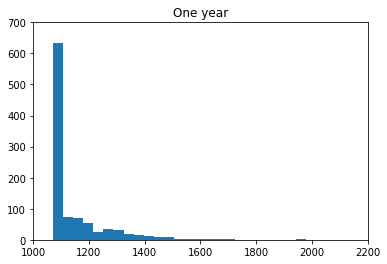

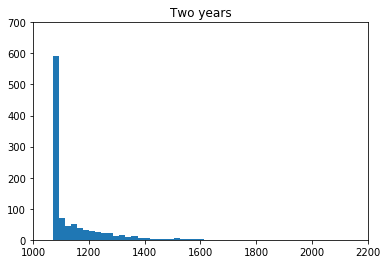

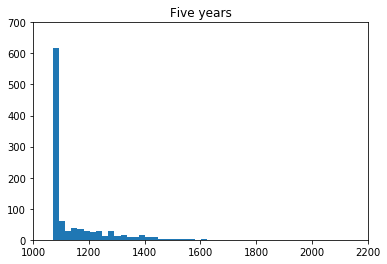

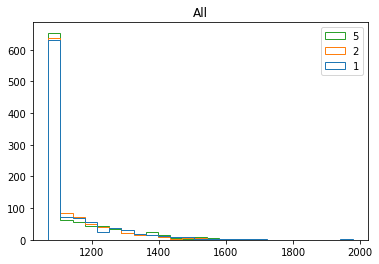

In [5]:
# Histograms
bins = 25
xMax = 2200
xMin = 1000
yMax = 700 * m/1000 # Dynamical scale
yMin = 0

plt.hist(W_1, bins=bins)
plt.title('One year')
plt.axis([xMin, xMax, yMin, yMax])
plt.show()

plt.hist(W_2, bins=bins)
plt.title('Two years')
plt.axis([xMin, xMax, yMin, yMax])
plt.show()

plt.hist(W_5, bins=bins)
plt.title('Five years')
plt.axis([xMin, xMax, yMin, yMax])
plt.show()

plt.hist([W_1, W_2, W_5], bins, label=['1', '2', '5'], histtype='step')
plt.title('All')
plt.legend(prop={'size': 10})
plt.show()

# 2 Quantiles of the payoff
0.025, 0.5, 0.95 quantiles of the payoff.  
### Comment: 
At lower quantiles the payoff is the minimum payoff value 1070. Only when higher quantiles are calculated the value also detaches from the minimum payoff. 


In [6]:
q = [0.025, 0.5, 0.95]
Q = np.quantile(W_5, q)
print('0.025: ' + '{0:.2f}'.format(Q[0]))
print('0.05:  ' + '{0:.2f}'.format(Q[1]))
print('0.95:  ' + '{0:.2f}'.format(Q[2]))

0.025: 1070.00
0.05:  1070.00
0.95:  1387.07


# 3 How different weights affect the payoff
"Discuss how different weights in the basket affect the final payoff."  
  
i) set to zero the weight of the Index with highest volatility and to one the others  
* SX5E has the highest volatility  


ii) assume the basked is made of the SP 500 index only.  
* Set the SPX weight to 1, others to 0

Comment on this, report the expected payoff and the multipliers in the two cases. 

### Comment:
Weights affect the multiplier vector M. The payoff is slightly smaller with SX5E zero weight because of the lower volatility of that version of the contract.



In [7]:
vol_test = volatilities(data, '2019-02-25', '2014-02-25')
print('Vols: ')
print('SPX:  ' +'{0:.3f}'.format(vol_test[0]))
print('SX5E: ' +'{0:.3f}'.format(vol_test[1]))
print('HSX:  ' +'{0:.3f}'.format(vol_test[2]))
print('\n')

# i) SX5E zero weight
I_Weights = [50, 0, 50] # Index weights in basket
M = M_(data, '2019-02-25', I_Weights) # Multiplier vector
M_SX5E_Zero = M 

W_5 = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25')
P_5 = np.mean(W_5)
print('Payoff (SX5E zero weight): ' + '{0:.2f}'.format(P_5))
print("Weights:")
print('SPX:  ' +'{0:.3f}'.format(M_SX5E_Zero[0, 0]))
print('SX5E: ' +'{0:.3f}'.format(M_SX5E_Zero[1, 0]))
print('HSX:  ' +'{0:.3f}'.format(M_SX5E_Zero[2, 0]))
print('\n')

# ii) SPX only
I_Weights = [100, 0, 0] # Index weights in basket
M = M_(data, '2019-02-25', I_Weights) # Multiplier vector
M_SPX_Only = M

W_5 = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25')
P_5 = np.mean(W_5)
print('Payoff (SPX only): ' + '{0:.2f}'.format(P_5))
print("Weights:")
print('SPX:  ' +'{0:.3f}'.format(M_SPX_Only[0, 0]))
print('SX5E: ' +'{0:.3f}'.format(M_SPX_Only[1, 0]))
print('HSX:  ' +'{0:.3f}'.format(M_SPX_Only[2, 0]) + '\n')

print('Payoff (original): ' + '{0:.2f}'.format(P_5))

Vols: 
SPX:  0.133
SX5E: 0.181
HSX:  0.173


Payoff (SX5E zero weight): 1136.98
Weights:
SPX:  0.018
SX5E: 0.000
HSX:  0.002


Payoff (SPX only): 1138.71
Weights:
SPX:  0.036
SX5E: 0.000
HSX:  0.000

Payoff (original): 1138.71


# 4 Make a plot of the expected payoff against different risk free rates and different volatility values

i) r = 0.005 : 0.005 : 0.3  
ii) σ = 0.05 : 0.05 : 0.3

### Comment:
It can be seen that by increasing both volatility and risk free rates, the payoff of the contract increases. 


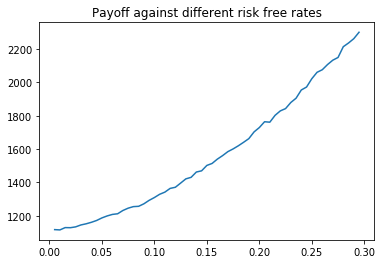

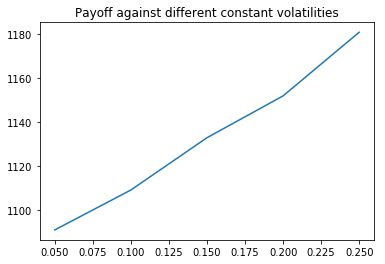

In [8]:
I_Weights = [100/3, 100/3, 100/3]
M = M_(data, '2019-02-25', I_Weights)

# i) 
r_range = np.arange(0.005, 0.3, 0.005)
P = np.empty(0)

for r in r_range:
    W_5 = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25')
    P_5 = np.mean(W_5)
    P = np.append(P, P_5)

plt.plot(r_range, P)
plt.title('Payoff against different risk free rates')
plt.show()

# ii)
r = 0.025
vol_range = np.arange(0.05, 0.3, 0.05)
P = np.empty(0)

for v in vol_range:
    vol = np.array([v, v, v])
    W_5 = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25', vol)
    P_5 = np.mean(W_5)
    P = np.append(P, P_5)

plt.plot(vol_range, P)
plt.title('Payoff against different constant volatilities')
plt.show()


# 5 Set a cap to payoff 
"Set a cap of 1300$ to contract."
### Comment: 

The cap limits the 0.95 quantile to the cap, 1300$ and lowers the expected payoff. Cap is a sensitive adjustment in a sense that it limits the expected payoff instantly when approaching the payoff distribution centre. 

In [9]:
#W/O cap 
Q = np.quantile(W_orig, 0.95)

# W/ cap of 1300$
W_5_cap = payoff(data, r, m, n, S_m, '2019-02-25', '2014-02-25', cap=1300)
PO_5_cap = np.mean(W_5_cap)
Q_cap = np.quantile(W_5_cap, 0.95)

print('Payoff no cap: ' + '{0:.2f}'.format(PO_orig))
print('0.95 quantile no cap: ' + '{0:.2f}'.format(Q)+'\n')
print('Payoff w/ cap: ' + '{0:.2f}'.format(PO_5_cap))
print('0.95 quantile w/ cap: ' + '{0:.2f}'.format(Q_cap))

Payoff no cap: 1134.28
0.95 quantile no cap: 1387.07

Payoff w/ cap: 1123.12
0.95 quantile w/ cap: 1300.00


# 6 Find the value of the contract on 25 March 2019   
"To do so you will need to evaluate the expected payoff on March 25 2019, and use the historical data up to this day. Comment your findings wrt. question 1."
### Comment: 
The payoff and price of the contract doesn't change much when calculated on March 25. 

In [10]:
# Expected payoff at 2019-03-25
S0 = initialIndexValues(data, '2019-03-25')
t[0] = pd.to_datetime('2019-03-25', format='%Y-%m-%d')
W_5 = payoff(data, r, m, n, S_m, '2019-03-25', '2014-02-25')

#Calculate payoffs
PO_5 = np.mean(W_5)

#Calculate fair prices by discounting, one month forward so time to payoff changes
P_5 = PO_5*np.exp(-r*(5-1/12))

Vol_5 = volatilities(data, '2019-03-25', '2014-02-25')

print('Price (2019-03-25): ' + '{0:.2f}'.format(P_5))
print('Payoff (2019-03-25):  ' + '{0:.2f}'.format(PO_5))
print("Mean of volatilities (2019-03-25): " + '{0:.3f}'.format(np.mean(Vol_5))+'\n')

print('Price (2019-02-25): ' + '{0:.2f}'.format(P_orig))
print('Payoff (2019-02-25):  ' + '{0:.2f}'.format(PO_orig))
print("Mean of volatilities (2019-02-25): " + '{0:.3f}'.format(np.mean(Vol_orig))+'\n')

Price (2019-03-25): 1010.48
Payoff (2019-03-25):  1142.64
Mean of volatilities (2019-03-25): 0.162

Price (2019-02-25): 1001.00
Payoff (2019-02-25):  1134.28
Mean of volatilities (2019-02-25): 0.162



# 7 Inverse reasoning 
"First, reconstruct the (hypothetical) historical basket values. That is,
the basket values that would have been observed in the past, based on the observed prices (use the same
multiplier as before, so that at t0 the index values is still 100 and each index accounts for 33%). Estimate
the basked volatility from this (unique) time series, simulate future basket values and determine its
expected payoff (and its fair price) under this approach. Comment on the two methods and tell whether
they should give the very same estimates or not."

### Comment: 
The price and payoff do not change much. The two methods should give similar estimates, but because of the 


In [11]:
basketValues = data
basketValues['Basket'] = data['SPX_Close'] * M[0] + data['SX5E_Close'] * M[1] + data['HSI_Close'] * M[2]

basketValues['LogReturns'] = np.log(basketValues['Basket']/basketValues['Basket'].shift(1))
vol = np.std(basketValues['LogReturns']/np.sqrt(1/252))

S = np.empty(n+1)
S[0] = 100
S_at = S

V = np.empty(m)
V_at = V
W = V

for i in range(m): #Loop through paths
    for j in range(1, n+1): #Loop through time steps
        dt = (t.iloc[j] - t.iloc[j-1]).days / 365
        
        S[j] = S[j-1] * np.exp((r - 0.5 * vol**2) * dt + vol * np.random.normal() * np.sqrt(dt))
        S_at[j] = S_at[j-1] * np.exp((r - 0.5 * vol**2) * dt - vol * np.random.normal() * np.sqrt(dt))

        V[i] = basketPayoff(S, S_m)
        V_at[i] = basketPayoff(S_at, S_m)
        W[i] = 0.5 * (V[i] + V_at[i])

PO = np.mean(W)
P = PO*np.exp(-r*5)

print('Price (basket): ' + '{0:.2f}'.format(P))
print('Payoff (basket):  ' + '{0:.2f}'.format(PO) + '\n')
print('Price (original): ' + '{0:.2f}'.format(P_orig))
print('Payoff (original):  ' + '{0:.2f}'.format(PO_orig))

Price (basket): 1002.25
Payoff (basket):  1135.69

Price (original): 1001.00
Payoff (original):  1134.28


# 8 Overall comment on the contract

* The payoff of the contract goes up when rates and volatility goes up. Given that rates are now very low and are supposed to go higher in the future, the payoff should grow in the future i. e. it is a good investment.
* But, there is always the risk that the economic cycle goes downwards and the indexes start to go down simultaneously as they are large equity indexes.
* Given that the contract consists of three different large indexes with diverse locations, I'd say that it it's very well diversified in general.

Runtime with 10^5 simulations appr. 3hrs 59min.


In [12]:
elapsed = timeit.default_timer() - start_time
print('Time elapsed with ' + str(m) +  ' iterations: '  + '{:.0f}'.format((elapsed-elapsed%60)/60) + ":" + '{:.0f}'.format(elapsed%60))  

Time elapsed with 1000 iterations: 2:55
